# ML Algorithm：
 - Inital input has 4 parameters：date，spend/sales，is_holiday，if_limit,dayofweek
 - encode date for ML; split into: year，month，day and encode them
 - 9 parameters used to train the model：
   1.  Past seven day sales
   2.  Day of the week
   3.  Date – the date was transformed into 3 different inputs
   4.  Season
   5.  If the date is a promotional event
   6.  If budget is limit on the date
   7.  Sales on the same day in the previous year











### Define helper function
helper funtion - is_holiday - If the date is a promotional event.Including Amazon Prime Day，Amazon Big Deal Prime Day，Black Friday and Cyber Monday。Sub helper function - one to include all BfCM，and one to include all PD and other promotional event。

 - **if there is any other event, add manually**


In [1]:
from datetime import datetime, timedelta

def get_nth_weekday(year, month, nth, weekday):
    """Helper function to find the nth occurrence of a weekday in a given month and year."""
    first_day = datetime(year, month, 1)
    first_weekday = first_day.weekday()

    # Calculate the offset to the first occurrence of the desired weekday
    days_to_weekday = (weekday - first_weekday) % 7
    first_occurrence = first_day + timedelta(days=days_to_weekday)

    # Calculate the nth occurrence of the weekday
    nth_occurrence = first_occurrence + timedelta(weeks=(nth - 1))
    return nth_occurrence

def get_black_friday(year):
    """Function to get the date of Black Friday for a given year."""
    # Thanksgiving is the 4th Thursday in November
    thanksgiving = get_nth_weekday(year, 11, 4, 3)  # 3 represents Thursday
    black_friday = thanksgiving + timedelta(days=1)  # Black Friday is the day after Thanksgiving
    return black_friday

def get_cyber_monday(year):
    """Function to get the date of Cyber Monday for a given year."""
    black_friday = get_black_friday(year)
    cyber_monday = black_friday + timedelta(days=3)  # Cyber Monday is the Monday after Black Friday
    return cyber_monday

def is_bfcm(date):
    """
    Function to extract the year from the input date and generate a list of Black Friday and Cyber Monday dates
    from 2022 to that year.
    
    Parameters:
    date (str or datetime): The input date.

    Returns:
    list: A list containing the years and their respective Black Friday and Cyber Monday dates.
    """
    # Convert the input date to a datetime object if it's a string
    if isinstance(date, str):
        date = pd.to_datetime(date)
    
    # Extract the year from the input date
    end_year = date.year

    # Generate the list of Black Friday and Cyber Monday dates from 2022 to the end_year
    dates = []
    for year in range(2022, end_year + 1):
        black_friday = get_black_friday(year)
        cyber_monday = get_cyber_monday(year)
        dates.append(black_friday)
        dates.append(cyber_monday)

    return dates


def is_holiday(date):
    if isinstance(date, str):
        date = pd.to_datetime(date)
    bfcm = is_bfcm(date)
    primeday = []
    for i in range(1,3):
        primeday.append(get_nth_weekday(2023, 7, 2, i))
        primeday.append(get_nth_weekday(2023, 10, 2, i))
        primeday.append(get_nth_weekday(2024, 7, 3, i))
        #add prime day Amazon selected each year
        primeday.append(get_nth_weekday(2024, 10, 2, i))
        #primeday.append(get_nth_weekday(2025, 7, 2, i))
    holidays = bfcm+primeday
    return date in holidays



In [2]:
primeday = []
for i in range(1,3):
    primeday.append(get_nth_weekday(2023, 7, 2, i))
    primeday.append(get_nth_weekday(2023, 10, 2, i))
    primeday.append(get_nth_weekday(2024, 7, 3, i))
    primeday.append(get_nth_weekday(2024, 10, 2, i))
print(primeday)

[datetime.datetime(2023, 7, 11, 0, 0), datetime.datetime(2023, 10, 10, 0, 0), datetime.datetime(2024, 7, 16, 0, 0), datetime.datetime(2024, 10, 8, 0, 0), datetime.datetime(2023, 7, 12, 0, 0), datetime.datetime(2023, 10, 11, 0, 0), datetime.datetime(2024, 7, 17, 0, 0), datetime.datetime(2024, 10, 9, 0, 0)]


### 定义helper function
if_limit是用来定义需要单独限制budget的法定节假日，这些天基本都会通过限制budget来控制花费，下面这段code可以帮助identify US federal holidays

In [3]:
import holidays

# Create a US holidays object
us_holidays = holidays.US()

# Define a function to check if a date is a federal holiday
def if_limit(date):
    return date in us_holidays

In [4]:
import pandas as pd
import numpy as np
from prophet import Prophet
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('timeseries.csv')

#overall
df_all = df.groupby(['date']).sum()
df_all = df_all.reset_index()
df_all.date=pd.to_datetime(df_all.date)
#mask = (df['date']<='2023-12-31') & (df['date']>='2023-01-01') 
#imp = df[mask]


ad_spend_series = df_all[['date','spd']]
#sales_series = df_all[['date','sales7d']]
#imp = df_all[['date','imp']]

def is_holiday0(date):
    holidays = ['07/11/2023', '07/12/2023', '10/10/2023', '10/11/2023', '11/24/2023', '11/27/2023', '11/25/2022', 
            '11/28/2022', '07/16/2024', '07/17/2024', '11/29/2024', '12/02/2024']
    holiday_dates = set(pd.to_datetime(holidays, format='%m/%d/%Y'))
    return date in holiday_dates



def if_limit0(date):
    holidays = ['07/04/2023', '05/29/2023', '09/04/2023', '11/23/2023', '12/25/2023', '05/27/2024', '07/04/2024', '09/02/2024','11/28/2024', '12/25/2024']
    holiday_dates = set(pd.to_datetime(holidays, format='%m/%d/%Y'))
    return date in holiday_dates


        
def cur_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 4
    elif month in [3, 4, 5]:
        return 1
    elif month in [6, 7, 8]:
        return 2
    elif month in [9, 10, 11]:
        return 3

def cur_weekday(date):
    if isinstance(date, str):
        date = pd.to_datetime(date)
    weekday = date.day_name()
    weekday_mapping = {'Monday': 1, 'Tuesday': 2, 'Wednesday': 3, 'Thursday': 4, 'Friday': 5, 'Saturday': 6, 'Sunday': 7}
    dow = weekday_mapping[weekday]
    return dow
        
# Past seven days of spend
ad_spend_series['past_7_days_spend'] = ad_spend_series['spd'].rolling(window=7).sum().shift(1)

# Day of the week
# Extract day of the week and encode it
ad_spend_series['day_of_week']=ad_spend_series['date'].apply(cur_weekday)

week = ad_spend_series['day_of_week'].unique()

# Encode date into year, month, and day
ad_spend_series['year'] = ad_spend_series['date'].dt.year
ad_spend_series['month'] = ad_spend_series['date'].dt.month
ad_spend_series['day'] = ad_spend_series['date'].dt.day

# Season
ad_spend_series['season'] = ad_spend_series['date'].apply(cur_season)

# Is holiday
ad_spend_series['is_holiday'] = ad_spend_series['date'].apply(is_holiday)
ad_spend_series['if_limit'] = ad_spend_series['date'].apply(if_limit)

# Spend on the same day in the previous year
ad_spend_series['spend_same_day_last_year'] = ad_spend_series['spd'].shift(365)

# Dropping rows with NaN values which resulted from shifting operations
ad_spend_series.dropna(inplace=True)

# Display the DataFrame
print(ad_spend_series.columns)


Index(['date', 'spd', 'past_7_days_spend', 'day_of_week', 'year', 'month',
       'day', 'season', 'is_holiday', 'if_limit', 'spend_same_day_last_year'],
      dtype='object')


In [5]:
print(ad_spend_series['date'].min())
print(ad_spend_series['date'].max())

2023-10-09 00:00:00
2025-01-02 00:00:00


<Figure size 1000x600 with 0 Axes>

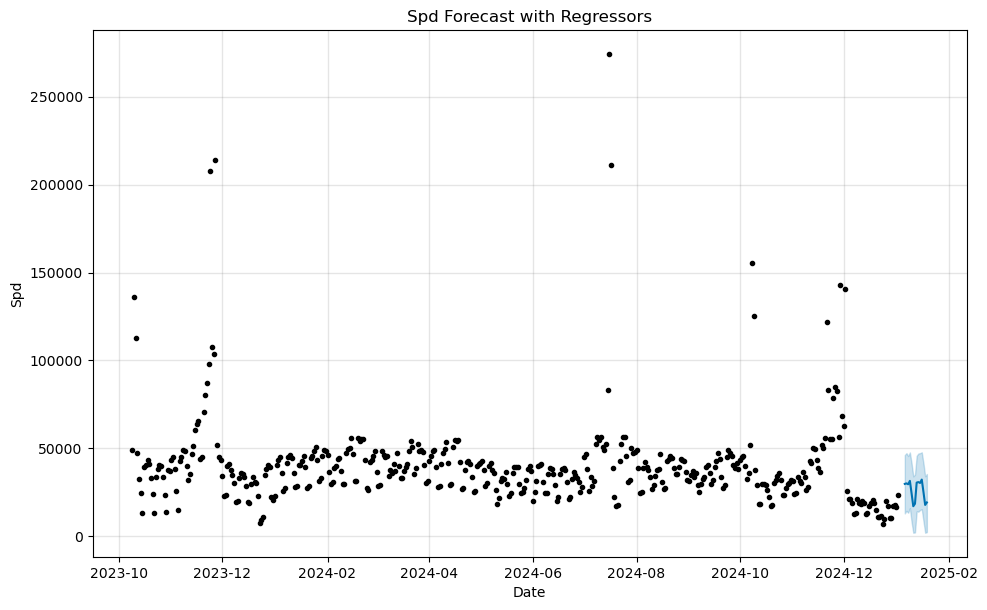

In [6]:
df = ad_spend_series
# Preparing the data for Prophet with regressors
df['date'] = pd.to_datetime(df['date'])
df_spd = df.rename(columns={'date': 'ds', 'spd': 'y'})

# Initialize the Prophet model
model_spd = Prophet()

# Add additional regressors
model_spd.add_regressor('past_7_days_spend')
model_spd.add_regressor('day_of_week')
model_spd.add_regressor('year')
model_spd.add_regressor('month')
model_spd.add_regressor('day')
model_spd.add_regressor('season')
model_spd.add_regressor('is_holiday')
model_spd.add_regressor('if_limit')
model_spd.add_regressor('spend_same_day_last_year')

# Fit the model
model_spd.fit(df_spd)

# Create future dataframe from Q3 2024-06-30 to 2024-09-28
# Create future dataframe from Q4 2024-06-30 to 2024-09-28
future_dates = pd.date_range(start='2025-01-06', end='2025-1-19', freq='D')
future_spd = pd.DataFrame(future_dates, columns=['ds'])

# Add future values for the regressors
future_spd['past_7_days_spend'] = df['past_7_days_spend'].iloc[-1]
future_spd['day_of_week'] = future_spd['ds'].apply(cur_weekday)
future_spd['year'] = future_spd['ds'].dt.year
future_spd['month'] = future_spd['ds'].dt.month
future_spd['day'] = future_spd['ds'].dt.day
future_spd['season'] = future_spd['ds'].apply(cur_season)
future_spd['is_holiday'] = future_spd['ds'].apply(is_holiday) # Adjust based on actual holiday dates
future_spd['if_limit'] = future_spd['ds'].apply(if_limit) # Adjust based on actual holiday dates
future_spd['spend_same_day_last_year'] = df['spend_same_day_last_year'].iloc[-1]



# Predict future sales
forecast_spd = model_spd.predict(future_spd)

# Plot the forecast
plt.figure(figsize=(10, 6))
model_spd.plot(forecast_spd, xlabel='Date', ylabel='Spd')
plt.title('Spd Forecast with Regressors')
plt.grid(True)
plt.show()

In [7]:
train_df = df_spd[:-30]
test_df = df_spd[-30:]
model_mape = Prophet()
model_mape.add_regressor('past_7_days_spend')
model_mape.add_regressor('day_of_week')
model_mape.add_regressor('year')
model_mape.add_regressor('month')
model_mape.add_regressor('day')
model_mape.add_regressor('season')
model_mape.add_regressor('is_holiday')
model_mape.add_regressor('if_limit')
model_mape.add_regressor('spend_same_day_last_year')
model_mape.fit(train_df)

future_df = test_df.drop(columns=['y'])
forecast_df = model_mape.predict(future_df)

mape = mean_absolute_percentage_error(test_df['y'], forecast_df['yhat'])
print(f'Test MAPE: {mape:.2%}')

17:20:48 - cmdstanpy - INFO - Chain [1] start processing
17:20:48 - cmdstanpy - INFO - Chain [1] done processing


Test MAPE: 104.87%


通过加入federal holiday的function将MAPE从26.16%降到24.63%，
经过prime day之后变成43.38%。。。

In [8]:
#forecast_spd[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#forecast_spd[['ds', 'yhat']].head(60)
forecast_spd[['ds', 'yhat']].tail(49)

,ds,yhat
0,2025-01-06,29840.033383
1,2025-01-07,30134.263784
2,2025-01-08,29627.091584
3,2025-01-09,31556.761382
4,2025-01-10,24468.225122
5,2025-01-11,17147.086107
6,2025-01-12,18554.935319
7,2025-01-13,30575.912443
8,2025-01-14,30870.142844
9,2025-01-15,30362.970644


In [9]:
ad_sales_series = df_all[['date','sales7d']]

# Past seven days of spend
ad_sales_series['past_7_days_sales'] = ad_sales_series['sales7d'].rolling(window=7).sum().shift(1)

# Day of the week
# Extract day of the week and encode it
ad_sales_series['day_of_week']=ad_sales_series['date'].apply(cur_weekday)

week = ad_sales_series['day_of_week'].unique()

# Encode date into year, month, and day
ad_sales_series['year'] = ad_sales_series['date'].dt.year
ad_sales_series['month'] = ad_sales_series['date'].dt.month
ad_sales_series['day'] = ad_sales_series['date'].dt.day

# Season
ad_sales_series['season'] = ad_sales_series['date'].apply(cur_season)

# Is holiday
ad_sales_series['is_holiday'] = ad_sales_series['date'].apply(is_holiday)
ad_sales_series['if_limit'] = ad_sales_series['date'].apply(if_limit)

# Spend on the same day in the previous year
ad_sales_series['sales_same_day_last_year'] = ad_sales_series['sales7d'].shift(365)

# Dropping rows with NaN values which resulted from shifting operations
ad_sales_series.dropna(inplace=True)

# Display the DataFrame
print(ad_sales_series.columns)

Index(['date', 'sales7d', 'past_7_days_sales', 'day_of_week', 'year', 'month',
       'day', 'season', 'is_holiday', 'if_limit', 'sales_same_day_last_year'],
      dtype='object')


<Figure size 1000x600 with 0 Axes>

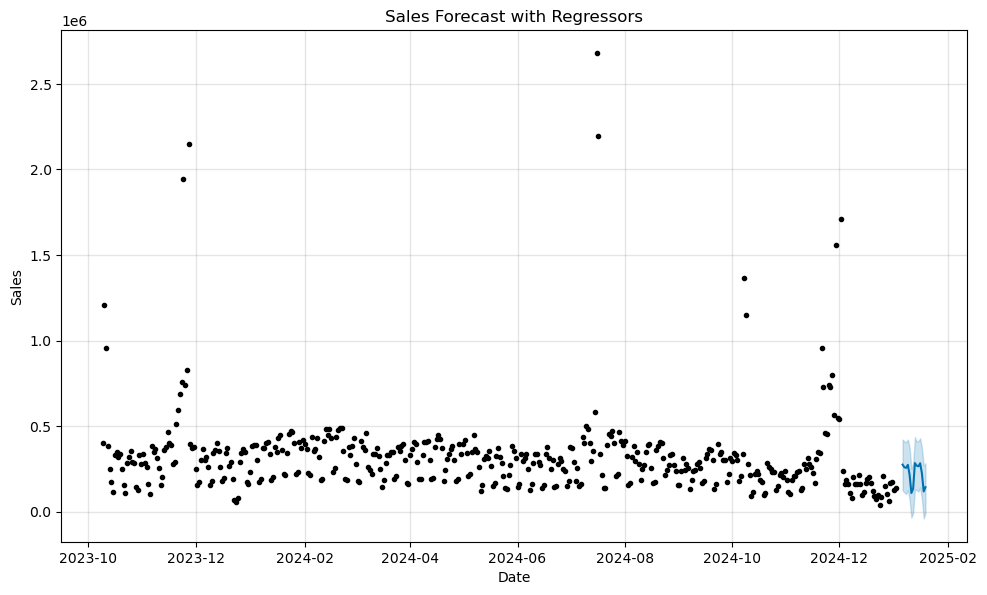

In [10]:
df = ad_sales_series
# Preparing the data for Prophet with regressors
df['date'] = pd.to_datetime(df['date'])
df_sales = df.rename(columns={'date': 'ds', 'sales7d': 'y'})

# Initialize the Prophet model
model_sales = Prophet()

# Add additional regressors
model_sales.add_regressor('past_7_days_sales')
model_sales.add_regressor('day_of_week')
model_sales.add_regressor('year')
model_sales.add_regressor('month')
model_sales.add_regressor('day')
model_sales.add_regressor('season')
model_sales.add_regressor('is_holiday')
model_sales.add_regressor('if_limit')
model_sales.add_regressor('sales_same_day_last_year')

# Fit the model
model_sales.fit(df_sales)

# Create future dataframe from 2024-06-30 to 2024-09-28
future_dates = pd.date_range(start='2025-01-06', end='2025-1-19', freq='D')
future_sales = pd.DataFrame(future_dates, columns=['ds'])

# Add future values for the regressors
future_sales['past_7_days_sales'] = df['past_7_days_sales'].iloc[-1]
future_sales['day_of_week'] = future_spd['ds'].apply(cur_weekday)
future_sales['year'] = future_spd['ds'].dt.year
future_sales['month'] = future_spd['ds'].dt.month
future_sales['day'] = future_spd['ds'].dt.day
future_sales['season'] = future_spd['ds'].apply(cur_season)
future_sales['is_holiday'] = future_spd['ds'].apply(is_holiday) # Adjust based on actual holiday dates
future_sales['if_limit'] = future_spd['ds'].apply(if_limit) # Adjust based on actual holiday dates
future_sales['sales_same_day_last_year'] = df['sales_same_day_last_year'].iloc[-1]



# Predict future sales
forecast_sales = model_sales.predict(future_sales)

# Plot the forecast
plt.figure(figsize=(10, 6))
model_sales.plot(forecast_sales, xlabel='Date', ylabel='Sales')
plt.title('Sales Forecast with Regressors')
plt.grid(True)
plt.show()

In [11]:
train_df = df_sales[:-30]
test_df = df_sales[-30:]
model_mape_sales = Prophet()
model_mape_sales.add_regressor('past_7_days_sales')
model_mape_sales.add_regressor('day_of_week')
model_mape_sales.add_regressor('year')
model_mape_sales.add_regressor('month')
model_mape_sales.add_regressor('day')
model_mape_sales.add_regressor('season')
model_mape_sales.add_regressor('is_holiday')
model_mape_sales.add_regressor('if_limit')
model_mape_sales.add_regressor('sales_same_day_last_year')
model_mape_sales.fit(train_df)

future_df = test_df.drop(columns=['y'])
forecast_df = model_mape_sales.predict(future_df)

mape = mean_absolute_percentage_error(test_df['y'], forecast_df['yhat'])
print(f'Test MAPE: {mape:.2%}')

17:20:49 - cmdstanpy - INFO - Chain [1] start processing
17:20:49 - cmdstanpy - INFO - Chain [1] done processing


Test MAPE: 103.04%


In [12]:
#forecast_sales[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
#forecast_sales[['ds', 'yhat']].head(42)
forecast_sales[['ds', 'yhat']].tail(49)

,ds,yhat
0,2025-01-06,275132.423993
1,2025-01-07,260022.973564
2,2025-01-08,256087.669650
3,2025-01-09,274057.949969
4,2025-01-10,214482.674999
5,2025-01-11,109228.342260
6,2025-01-12,134327.493231
7,2025-01-13,284313.380313
8,2025-01-14,269203.929884
9,2025-01-15,265268.625970
